In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
import tensorflow as tf
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.signal import find_peaks

In [2]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images 
        self.transform = transform  
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]  
        
        print(f"Loading image: {os.path.basename(img_path)}") 

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image  

In [3]:
dataset_dir = 'allfrog'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

image_paths = [] 

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith('.png'):
            img_path = os.path.join(root, file)
            image_paths.append(img_path)

print(f"Number of images: {len(image_paths)}") 

dataset = CustomDataset(image_paths, transform=transform)

print(f"Total number of images in the dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

features_list = []

for batch_idx, batch_images in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}/{len(dataloader)} - Processing batch of {batch_images.size(0)} images")

  
    flattened = batch_images.view(batch_images.size(0), -1).numpy()
    features_list.append(flattened)

    
    print(f"Current batch size: {batch_images.size(0)}")
    print(f"Image tensor shape before flattening: {batch_images.shape}")
    print(f"Flattened features shape: {flattened.shape}")


features = np.vstack(features_list)

print(f"Total number of images processed: {len(features)}")
print(f"Features shape after stacking: {features.shape}")


print(f"Number of images before scaling: {features.shape[0]}") 

Number of images: 5500
Total number of images in the dataset: 5500
Loading image: 0.png
Loading image: 1.png
Loading image: 10.png
Loading image: 100.png
Loading image: 1000.png
Loading image: 1001.png
Loading image: 1002.png
Loading image: 1003.png
Loading image: 1004.png
Loading image: 1005.png
Loading image: 1006.png
Loading image: 1007.png
Loading image: 1008.png
Loading image: 1009.png
Loading image: 101.png
Loading image: 1010.png
Loading image: 1011.png
Loading image: 1012.png
Loading image: 1013.png
Loading image: 1014.png
Loading image: 1015.png
Loading image: 1016.png
Loading image: 1017.png
Loading image: 1018.png
Loading image: 1019.png
Loading image: 102.png
Loading image: 1020.png
Loading image: 1021.png
Loading image: 1022.png
Loading image: 1023.png
Loading image: 1024.png
Loading image: 1025.png
Batch 1/172 - Processing batch of 32 images
Current batch size: 32
Image tensor shape before flattening: torch.Size([32, 3, 224, 224])
Flattened features shape: (32, 150528)
Lo

In [4]:
# Scale the feature vectors using StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print(f"Scaled features shape: {features_scaled.shape}")  # This should also be (5500, 150528)

pca = PCA(n_components=50) 
features_reduced = pca.fit_transform(features)


print(f"Number of images (image_paths list): {len(image_paths)}") 

# Initialize ResNet18 model for feature extraction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

model.fc = torch.nn.Identity() 
model = model.to(device)

# Features extraction 
features_resnet = []
total_images_resnet = 0 
for batch_idx, images in enumerate(dataloader):
    batch_size = images.size(0)
    total_images_resnet += batch_size 

    print(f"Batch {batch_idx + 1}/{len(dataloader)} - Processing batch of {batch_size} images")
    print(f"Current batch size: {images.size(0)}")
    print(f"Image tensor shape before flattening: {images.shape}")
    
    # Extract features using ResNet18
    with torch.no_grad():
        images = images.to(device)
        output = model(images)
    
    features_resnet.append(output.cpu().numpy())
    
print(f"Total number of images processed (ResNet): {total_images_resnet}")

features_resnet = np.vstack(features_resnet)
print(f"Features shape after stacking (ResNet): {features_resnet.shape}")

Scaled features shape: (5500, 150528)
Number of images (image_paths list): 5500
Loading image: 0.png
Loading image: 1.png
Loading image: 10.png
Loading image: 100.png
Loading image: 1000.png
Loading image: 1001.png
Loading image: 1002.png
Loading image: 1003.png
Loading image: 1004.png
Loading image: 1005.png
Loading image: 1006.png
Loading image: 1007.png
Loading image: 1008.png
Loading image: 1009.png
Loading image: 101.png
Loading image: 1010.png
Loading image: 1011.png
Loading image: 1012.png
Loading image: 1013.png
Loading image: 1014.png
Loading image: 1015.png
Loading image: 1016.png
Loading image: 1017.png
Loading image: 1018.png
Loading image: 1019.png
Loading image: 102.png
Loading image: 1020.png
Loading image: 1021.png
Loading image: 1022.png
Loading image: 1023.png
Loading image: 1024.png
Loading image: 1025.png
Batch 1/172 - Processing batch of 32 images
Current batch size: 32
Image tensor shape before flattening: torch.Size([32, 3, 224, 224])
Loading image: 1026.png
Load

In [5]:
print(f"Features shape: {features_reduced.shape}")
print(f"Number of images: {len(image_paths)}")

dbscan = DBSCAN(eps=120, min_samples=5)
labels = dbscan.fit_predict(features_reduced)

unique_labels, label_counts = np.unique(labels, return_counts=True)
print(f"Unique DBSCAN labels: {unique_labels}")
print(f"Label counts: {label_counts}")

if len(image_paths) == len(labels):
    clean_images = []
    poisoned_images = []
    for idx, label in enumerate(labels):
        if label == -1:
            poisoned_images.append(image_paths[idx])  # Noise points are considered poisoned
        else:
            clean_images.append(image_paths[idx])  # All other points are considered clean
else:
    print(f"Error: Mismatch between number of images ({len(image_paths)}) and number of labels ({len(labels)})")

print(f"Number of clean images: {len(clean_images)}")
print(f"Number of poisoned images: {len(poisoned_images)}")

all_images = []

for image in clean_images:
    all_images.append((image, 'clean'))

for image in poisoned_images:
    all_images.append((image, 'poisoned'))

all_images_sorted = sorted(all_images, key=lambda x: os.path.basename(x[0]))

with open('labels.txt', 'w') as f:    
    # Write the sorted images with their labels
    for image, label in all_images_sorted:
        f.write(f"{os.path.basename(image)}: {label}\n")  

print("Results written to labels.txt in lexicographical order")

Features shape: (5500, 50)
Number of images: 5500
Unique DBSCAN labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36]
Label counts: [ 500 4765   11    6    7    5    7    5    9    5    7    9   10    5
    7    5    6    5    7    5    5    5    8    6    5    6    5   15
    6    6    8    5    7    5    5    5    6    6]
Number of clean images: 5000
Number of poisoned images: 500
Results written to labels.txt in lexicographical order


In [6]:
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Cluster labels: {dict(zip(unique_labels, counts))}")

clean_labels = [labels[i] for i in range(len(clean_images))]
poisoned_labels = [labels[i] for i in range(len(poisoned_images))]

# Count the occurrences of labels in clean and poisoned groups
clean_label_counts = {label: clean_labels.count(label) for label in set(clean_labels)}
poisoned_label_counts = {label: poisoned_labels.count(label) for label in set(poisoned_labels)}

print("Clean images label distribution:", clean_label_counts)
print("Poisoned images label distribution:", poisoned_label_counts)

Cluster labels: {-1: 500, 0: 4765, 1: 11, 2: 6, 3: 7, 4: 5, 5: 7, 6: 5, 7: 9, 8: 5, 9: 7, 10: 9, 11: 10, 12: 5, 13: 7, 14: 5, 15: 6, 16: 5, 17: 7, 18: 5, 19: 5, 20: 5, 21: 8, 22: 6, 23: 5, 24: 6, 25: 5, 26: 15, 27: 6, 28: 6, 29: 8, 30: 5, 31: 7, 32: 5, 33: 5, 34: 5, 35: 6, 36: 6}
Clean images label distribution: {0: 4338, 1: 11, 2: 6, 3: 7, 4: 5, 5: 7, 6: 5, 7: 9, 8: 4, 9: 7, 10: 8, 11: 10, 12: 5, 13: 7, 14: 5, 15: 6, 16: 4, 17: 6, 18: 4, 19: 5, 20: 4, 21: 8, 22: 5, 23: 5, 24: 5, 25: 5, 26: 13, 27: 6, 28: 6, 29: 8, 30: 4, 31: 6, 32: 5, 33: 5, 34: 3, 35: 6, 36: 4, -1: 443}
Poisoned images label distribution: {0: 437, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 36: 1, 11: 1, -1: 54}


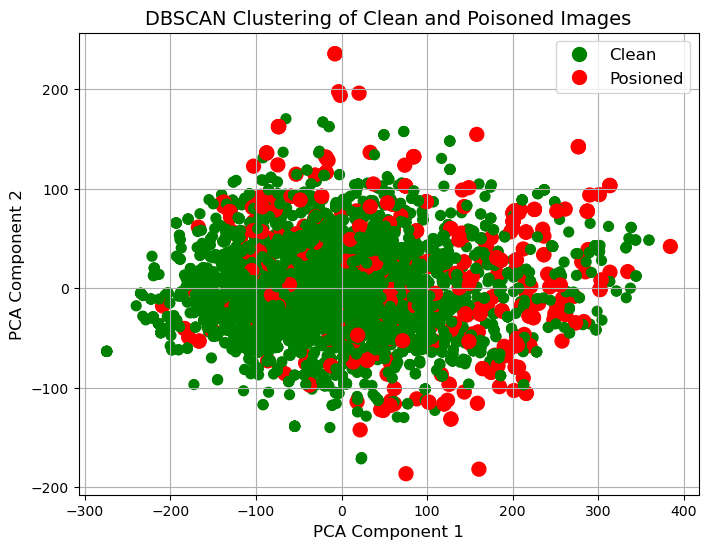

In [21]:
colors = np.array(['green' if label != -1 else 'red' for label in labels])
sizes = np.array([50 if label != -1 else 100 for label in labels])  # Larger points for noise (optional)

plt.figure(figsize=(8, 6))
plt.scatter(features_reduced[:, 0], features_reduced[:, 1], c=colors, s=sizes, marker='o')

plt.title("DBSCAN Clustering of Clean and Poisoned Images", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)

import matplotlib.lines as mlines

clean_line = mlines.Line2D([], [], marker='o', color='green', label='Clean', linestyle='None', markersize=10)
poisoned_line = mlines.Line2D([], [], marker='o', color='red', label='Posioned', linestyle='None', markersize=10)

plt.legend(handles=[clean_line, poisoned_line], loc='upper right', fontsize=12)

plt.grid(True)
plt.show()